# Practice querying MAST

This notebook tests some of the methods I think I will apply to extract the lightcurves of all the stars neighboring one of the clusters we're measuring. It also includes some tools to access CDIPS, a project that calculated and saved lightcurves for many clusters that we could potentially check ours against.

In [35]:
%matplotlib inline
from astroquery.mast import Catalogs
from astropy.io import ascii
import numpy as np
from astropy.table import Table
import os
import lightkurve as lk

import eleanor
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt

CLUSTER = "NGC 6231"
LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"

COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.784490, 9.934156), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113000", "-31.850000"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}

LOWER_LIMIT = 10
SCALE_FACTOR=1.5

In [54]:
if CLUSTER + ".dat" in os.listdir():
    brightData = Table.read(CLUSTER + ".dat", format="ascii")
else:
    catalogData = Catalogs.query_object(catalog="Tic",objectname=CLUSTER, radius="0.5 deg")
    brightData = catalogData[:]
    brightData = brightData[brightData["Tmag"] <= 13]
    ascii.write(brightData, CLUSTER + ".dat")
    
print(brightData[1000:1010])
print(len(brightData))
# Cluster coords: 253.53546, -41.82667

    ID           ra               dec        ... wdflag     dstArcSec     
--------- ---------------- ----------------- ... ------ ------------------
247566429 253.972226164741 -42.0645489162032 ...      0 1449.5006673043172
338738517 253.344182244367 -41.4502206825211 ...      0  1449.638587824605
339572897 253.641344327079  -41.431783822144 ...      0 1449.8609171121795
247261159 253.558276008695 -42.2293470496477 ...      0 1450.9207757918932
338738426 253.317994310905 -41.4574025871822 ...      0  1452.407264436899
337802219 252.996356460077  -41.865318382823 ...      0 1452.4375786792516
337806655  253.07725053885 -41.6120414419164 ...      0  1453.606896325688
340415548 253.837493749024 -41.4917650605298 ...     -1 1453.7939428329823
337803850 253.008633800288 -41.7313744599094 ...      0  1455.323806238903
247268545 253.782904744618 -42.1867119375014 ...      0 1455.3852660710568
1428


For this test, we're going to only check out one star. The index of this star is set here:

In [68]:
i=1000
coords = SkyCoord(ra=brightData[i]["ra"], dec=brightData[i]["dec"], unit=(u.deg, u.deg))
print(coords)

<SkyCoord (ICRS): (ra, dec) in deg
    (253.97222616, -42.06454892)>


## Eleanor method (slow and bad)

With a little experimenting, I have come to the conclusion that I can't make `lightkurve` generate its own postcards for these stars, but I can make `eleanor` do it. So here's the code to download the `eleanor` postcard.

Aside from the issues with this method, it is nice because `eleanor` seems to use shorter exposure images, so that the stars are more resolved, which is important for our purposes.

In [56]:
star = eleanor.Source(coords=coords, tc=True)

Inflating...


And here's how to display it.

Set MJD-OBS to 58624.458010 from DATE-OBS.
Set MJD-END to 58652.374665 from DATE-END'. [astropy.wcs.wcs]
100%|██████████| 1289/1289 [00:26<00:00, 49.04it/s]


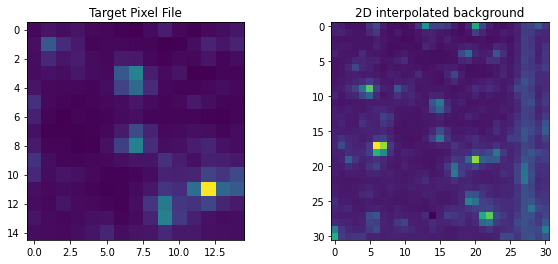

In [57]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=False)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.bkg_tpf[0])
ax2.set_title('2D interpolated background');

## Another, better method (fast and good)

We could try to cut the TPF straight out of the FFI that we downloaded for the cluster. To do this, we need a function that maps (RA, dec) $\rightarrow$(x, y on FFI).

In [73]:
### This function is flawed. I will fix it.

def globalToImageCoords(ra, dec, centerRA, centerDec):
    IMAGE_SIZE_PIXELS = 180
    IMAGE_SIZE_DEGREES = 1
    x = (ra - centerRA) * IMAGE_SIZE_PIXELS / IMAGE_SIZE_DEGREES + IMAGE_SIZE_PIXELS // 2
    y = (dec - centerDec) * IMAGE_SIZE_PIXELS / IMAGE_SIZE_DEGREES + IMAGE_SIZE_PIXELS // 2
    return (int(x), int(y))

Here's the goal: what if we use the background subtraction that was generated when we made the cluster lightcurves, so that all we have to do is make an aperture for each star and take the star's lightcurve? To do that, we need to download the ffi for the whole cluster (actually, we just have to take it from the directory it is already stored in since it was downloaded using *cluster\_lightcurves.ipynb*)

In [59]:
foundLocal = False
tpf = 0
for file in os.listdir(LIGHTKURVE_CACHE):
    if file.endswith("180x180_astrocut.fits"): # Confirm size
        if COORDS[CLUSTER][0] == float(file.split("_")[-4]): # Confirm RA
            if COORDS[CLUSTER][1] == float(file.split("_")[-3]): # Confirm dec
                tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                foundLocal = True
                break
if not foundLocal:
    raise Exception("This was supposed to be pre-downloaded :(")
    
avg_image = np.mean(tpf.flux, axis=0)

Now I need to make the masks for the cluster.

In [60]:
def countMaxima(data):
    stars = 0
    
    def getValue(x, y):
        if x < 0 or x >= data.shape[0] or y < 0 or y >= data.shape[0]:
            return 0 # Count this pixel as automatically smaller than everything else
        if np.isnan(data[x][y]):
            return 0 # Count this pixel as automatically smaller than everything else.
        if data[x][y] < LOWER_LIMIT:
            return 0 # Count this pixel as automatically smaller than everything else.
        return data[x][y]
        
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            b = data[x][y]
            if np.isnan(b): continue # Don't count nan pixels
            if b < LOWER_LIMIT: continue # Don't count pixels on edge of sector
            up = getValue(x, y-1)
            down = getValue(x, y+1)
            left = getValue(x-1, y)
            right = getValue(x+1, y)
            if b > max(up, down, left, right):
                stars += 1
    return stars

In [61]:
def getLimitMaximaMethod():
    numMaxima = countMaxima(avg_image)
    notNanMask = ~np.isnan(avg_image)
    notEdgeMask = avg_image > LOWER_LIMIT
    numPixels = np.count_nonzero(notNanMask & notEdgeMask) # Count the number of pixels that
        # are not nan and are greater than LOWER_LIMIT.
    n = 100 - SCALE_FACTOR * numMaxima / numPixels * 100
    return np.nanpercentile(avg_image, n)# Upper limit of the sky pixel flux range

In [62]:
upperLimit = getLimitMaximaMethod()
skyMask = ((avg_image >= LOWER_LIMIT) & # Exclude edge pixels
    (avg_image <= upperLimit)).reshape(180, 180).astype(bool)
starMask = ((avg_image > upperLimit)).reshape(180, 180).astype(bool)

The following method is not actually valid. I will have to remake the star mask, not simply cut it, because cutting it will include other, nearby stars.

In [69]:
### DON'T USE

POSTCARD_SIZE = 18

cutoutCenter = globalToImageCoords(coords.ra.value, coords.dec.value, COORDS[CLUSTER][0], COORDS[CLUSTER][1])
cutoutRect = [cutoutCenter[0] - POSTCARD_SIZE // 2, cutoutCenter[1] - POSTCARD_SIZE // 2, 
              cutoutCenter[0] + POSTCARD_SIZE // 2, cutoutCenter[1] + POSTCARD_SIZE // 2]
smallStarMask = np.zeros_like(starMask)
for x in range(cutoutRect[0], cutoutRect[2]):
    for y in range(cutoutRect[1], cutoutRect[3]):
        smallStarMask = starMask[x][y]
        
smallStarMask = smallStarMask.astype(bool)

0.4367661647409875 180.0


Drawing the cutout image:

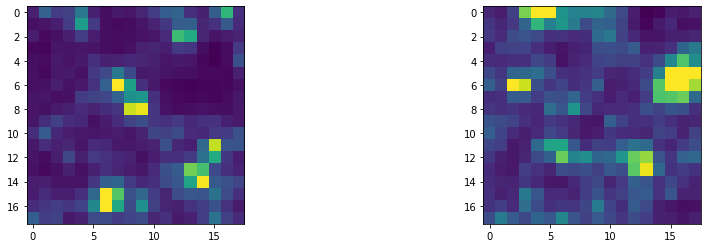

In [71]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4))
ax1.imshow(avg_image[cutoutRect[1]:cutoutRect[3],cutoutRect[0]:cutoutRect[2]], vmax = np.nanpercentile(avg_image, 95));
ax2.imshow(avg_image[cutoutRect[0]:cutoutRect[2],cutoutRect[1]:cutoutRect[3]], vmax = np.nanpercentile(avg_image, 95));

## CDIPS

Access the [CDIPS](https://archive.stsci.edu/hlsp/cdips#section-65c131d0-9994-46e6-a370-af9f2e3669cc) project. Don't run this. It took hours to run and then crashed.

In [ ]:
Please don't run this.

from astroquery.mast import Observations

# Search for CDIPS light curves within 0.001 degrees of V684 Mon.
obs_table = Observations.query_criteria(objectname="V684 Mon", radius=".001 deg", provenance_name="CDIPS")
print("Found " + str(len(obs_table)) + " CDIPS light curves.")
# Get list of available products for this Observation.
cdips_products = Observations.get_product_list(obs_table)
# Download the products for this Observation.
manifest = Observations.download_products(cdips_products)

# Search for CDIPS light curves directly based on TIC ID.
ticid = '220314428'
obs_table = Observations.query_criteria(target_name=ticid, provenance_name="CDIPS")
print("Found " + str(len(obs_table)) + " CDIPS light curves.")
# Get list of available products for this Observation.
cdips_products = Observations.get_product_list(obs_table)
# Download the products for this Observation.
manifest = Observations.download_products(cdips_products)
print("Done")

# Get all CDIPS light curves for a given Sector, may not work
# depending on bandwidth and traffic, we suggest you use bulk
# download scripts instead.
sector_num = '6'
print('Querying for CDIPS Sector ' + sector_num + " Observations...")
obsTable = Observations.query_criteria(provenance_name = "CDIPS",
                                       sequence_number = sector_num)
print("Found a total of " + str(len(obsTable)) + " CDIPS targets.")
print('Downloading data products for these observations...')
for obs in obsTable:
    data_products = Observations.get_product_list(obs)
    Observations.download_products(data_products)